## Parámetros Generales

In [1]:
# Idioma
language = "eng" # eng, spa, ger, fre

# Directorio donde se guardaran los modelos generados
path_model = "./models/"

## Importación de librerías

In [2]:
import csv
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import spacy
import torch
import tensorflow as tf

from catboost import CatBoostClassifier
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.feature_extraction.text import CountVectorizer

## Preparación de ficheros con términos

**Ficheros**

In [3]:
files = {
    "eng": [
        {"path": "./muestra/", "raw": "raw_occupational_therapy_eng.json", "gold": "gold_occupational_therapy_eng.json"},
        {"path": "./muestra/", "raw": "raw_oc_eng.json", "gold": "gold_oc_eng.json"}
    ],
    "fre": [
        {"path": "./muestra/", "raw": "raw_occupational_therapy_fre.json", "gold": "gold_occupational_therapy_fre.json"}
    ],
    "ger": [
        {"path": "./muestra/", "raw": "raw_occupational_therapy_ger.json", "gold": "gold_occupational_therapy_ger.json"}
    ],
    "spa": [
        {"path": "./muestra/", "raw": "raw_occupational_therapy_spa.json", "gold": "gold_occupational_therapy_spa.json"}
    ]  
}

**Modelos Spacy**

In [4]:
spacy_models = json.loads('''{
	"bul": {"sm": null, "lg": null},
	"hrv": {"sm": "hr_core_news_sm", "lg": "hr_core_news_lg"},
	"cze": {"sm": null, "lg": null},
	"dan": {"sm": "da_core_news_sm", "lg": "da_core_news_trf"},
	"dut": {"sm": "nl_core_news_sm", "lg": "nl_core_news_lg"},
	"eng": {"sm": "en_core_web_sm", "lg": "en_core_web_trf"},
	"est": {"sm": null, "lg": null},
	"fin": {"sm": "fi_core_news_sm", "lg": "fi_core_news_lg"},
	"fre": {"sm": "fr_core_news_sm", "lg": "fr_dep_news_trf"},
	"ger": {"sm": "de_core_news_sm", "lg": "de_dep_news_trf"},
	"gre": {"sm": "el_core_news_sm", "lg": "el_core_news_lg"},
	"hun": {"sm": null, "lg": null},
	"gle": {"sm": null, "lg": null},
	"ita": {"sm": "it_core_news_sm", "lg": "it_core_news_lg"},
	"lav": {"sm": null, "lg": null},
	"lit": {"sm": "lt_core_news_sm", "lg": "lt_core_news_lg"},
	"mlt": {"sm": null, "lg": null},
	"pol": {"sm": "pl_core_news_sm", "lg": "pl_core_news_lg"},
	"por": {"sm": "pt_core_news_sm", "lg": "pt_core_news_lg"},
	"rum": {"sm": "ro_core_news_sm", "lg": "ro_core_news_lg"},
	"rus": {"sm": "ru_core_news_sm", "lg": "ru_core_news_lg"},
	"slo": {"sm": null, "lg": null},
	"slv": {"sm": null, "lg": null},
	"spa": {"sm": "es_core_news_sm", "lg": "es_dep_news_trf"},
	"swe": {"sm": null, "lg": null}
}''')

### Definición de Funciones
**Función para cargar ficheros de datos**

In [5]:
def open_files(path, raw_file, gold_file):
    
    raw_file = path + raw_file
    gold_file = path + gold_file
    
    print("raw_file: ", raw_file)
    print("gold_file: ", gold_file)

    raw_data = json.loads(open(raw_file).read())
    gold_data = json.loads(open(gold_file).read())
    
    return raw_data, gold_data

**Si el idioma lo permite, convierte términos a minúscula**

In [6]:
def lower_case_terms(language, raw_terms, gold_terms):

    lower_languages = ["eng", "spa"]

    # Si el idioma lo permite, crea un conjunto (set) para eliminar duplicados y convertir elementos a minúscula
    if language in lower_languages:

        raw_terms_lower = {elemento.lower() for elemento in raw_terms}
        gold_terms_lower = {elemento.lower() for elemento in gold_terms}

        raw_terms = list(raw_terms_lower)
        gold_terms = list(gold_terms_lower)

        raw_terms.sort()
        gold_terms.sort()

    print("Términos raw:", len(raw_terms))
    print(raw_terms[:10])

    print("Términos gold:", len(gold_terms))
    print(gold_terms[:10])
    
    return raw_terms, gold_terms


**Crear lista con todos los términos**

In [7]:
def create_term_list(raw_terms, gold_terms):

    # Convertir la lista gold a un conjunto para una comparación más eficiente
    gold_set = set(gold_terms)

    # Incluimos todos los elementos de la lista gold y un indicador a True de elemento válido
    full_list = [(term, True) for term in gold_terms]

    # Iterar sobre los elementos de raw_terms para incluir los términos que no estén en gold_terms
    for elemento in raw_terms:
        if elemento in gold_set:  # Verificar si elemento está en la lista gold
            _
        else:
            full_list.append((elemento, False))  # Agregar la frase con indicador False (elemento no válido)

    print("Full list: ", len(full_list))
    print(full_list)   

    return full_list

**Mezclando los datos**

In [8]:
def mix_list(full_list):
    # Como los raw_terms están al final se mezclan los datos para que queden distribuidos por toda la lista
    # seed = 1337
    rng = np.random.RandomState(seed=1337)
    rng.shuffle(full_list)

**Obtiene etiquetas POS (Spacy)**

In [9]:
def get_POS_tags(full_list):
    # Para cada palabra que forme parte de los términos en full_list se obtiene su etiqueta POS
    # La idea es proporcionar mayor información a la hora de poder decidir si un término es gold 

    # Cargar el modelo Spacy del idioma
    nlp = spacy.load(spacy_models[language]["sm"])

    term_list =[]
    pos_list = []
    ind_list = []

    for term, ind_is_gold in full_list:

        doc = nlp(term)

        pos = [token.pos_ for token in doc]

        # TERMINOS
        term_list.append(term)
        # POS
        pos_list.append(pos)
        # INDICADORES
        ind_list.append(ind_is_gold)

    print("term_list: ", len(term_list), term_list)
    print("pos_list: ", len(pos_list), pos_list)
    print("ind_list: ", len(ind_list), ind_list)
    
    return term_list, pos_list, ind_list

**Función para tokenizar listas**

In [10]:
# Con el tokenizador se convierten los textos en secuencias de números enteros. Cada palabra en los textos es reemplazada por su índice 
# correspondiente en el vocabulario aprendido por el tokenizador.
# Al finalizar este proceso se devolverán las secuencias de números enteros que representan los textos de input_list, donde cada palabra ha sido 
# reemplazada por su índice numérico en el vocabulario creado por el tokenizador. 

def tokenizar_lista(input_list):

    # Preprocesamiento - Crear un objeto Tokenizer
    tokenizer = Tokenizer()

    # Ajustar el tokenizador a los textos
    tokenizer.fit_on_texts(input_list)

    # Convertir los textos en secuencias de números enteros
    output_list = tokenizer.texts_to_sequences(input_list)
    
    return output_list, tokenizer.word_index

# Prueba
print(tokenizar_lista([['NOUN', 'NOUN'], ['ADJ', 'NOUN'], ['ADJ', 'NOUN', 'NOUN'], ['ADJ', 'NOUN', 'NOUN']]))

([[1, 1], [2, 1], [2, 1, 1], [2, 1, 1]], {'noun': 1, 'adj': 2})


**Función para homogenizar listas**

In [11]:
# El número de elementos depende de la cantidad de palabras por lo que se homogeniza la lista para que todos los elementos tengan 
# el mismo número de elementos
def homogenizar_lista(input_list):
    
    # Encuentra la longitud máxima de los elementos en la input_list
    max_len = max(len(item) for item in input_list)

    # Rellena elementos de la input_list con ceros para que tengan la misma longitud
    output_list = [item + [0] * (max_len - len(item)) for item in input_list]

    return output_list

# Prueba
homogenizar_lista([[92, 93, 179], [10, 15, 31], [430, 16], [431], [180, 258, 24], [92, 259, 1], [1, 31]])

[[92, 93, 179],
 [10, 15, 31],
 [430, 16, 0],
 [431, 0, 0],
 [180, 258, 24],
 [92, 259, 1],
 [1, 31, 0]]

**Función para vectorizar listas**

In [12]:
# La función TfidfVectorizer convierte una colección de documentos en bruto en una matriz de características TF-IDF.
# TF-IDF es una medida de importancia de una palabra en un documento, teniendo en cuenta la frecuencia de la palabra en el documento y 
# la frecuencia de la palabra en todos los documentos.

def vectorizar_lista(input_list):
    # Transformación de input_list a valores numéricos

    # Crear un vectorizador de texto
    vectorizer = TfidfVectorizer(lowercase=False)

    # Transformar los datos de texto en características numéricas
    output_list = vectorizer.fit_transform(input_list)
    oth = vectorizer.get_feature_names_out()

    print("get_feature_names_out: ", type(oth), oth.shape, oth)
    
    return output_list

**Función para calcular la matriz de confusión en porcentajes**

In [13]:
def calculate_confusion_matrix_percent(cm):
    total_predictions = cm.sum()  # Suma total de predicciones en el pliegue
    cm_percentage = (cm / total_predictions * 100).round(2)  # Multiplicar por el total de predicciones y redondear a dos decimales
    return (cm_percentage)

**Función para dibujar matriz de confusión**

In [14]:
def plot_confusion_matrix(cm, classes=['False', 'True'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (3,2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Función para preparar y mostrar la matriz de confusión para modelos creados con TensorFlow/Kera**

In [15]:
def prepare_confus_matrix_tf(predictions, y_test, limits=[0.5]):
    
    results_return = []
    for limit in limits:
        # Clasificación binaria y valores mayores a limit
        predicted_labels = (predictions > limit).astype('int32')  
        
        accuracy_prediction_tf = accuracy_score(y_test, predicted_labels)
        print(f'Precisión con {limit*100}%: {accuracy_prediction_tf:.4f}')
        results_return.append(accuracy_prediction_tf)

        # Obtener la matriz de confusión
        conf_matrix = confusion_matrix(y_test, predicted_labels)
        conf_matrix_perc = calculate_confusion_matrix_percent(conf_matrix)
        plot_confusion_matrix(conf_matrix_perc, title=f'Confusion matrix - Prediction > {limit*100}%')  
        
    return results_return 

**Función para mostrar gráfico del history de modelos TensorFlow/Keras**

In [16]:
# Graficar datos history 
def graphic_history(history):
    pd.DataFrame(history.history).plot(figsize=(5, 3))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

**Función para extraer los términos de los datos**

In [17]:
def obtain_terms_from_data(language, raw_data, gold_data):
    
    # Extrae los términos raw y gold
    raw_terms = [term['forms'][language][0]['text'] for term in raw_data]
    gold_terms = [term['forms'][language][0]['text'] for term in gold_data]
    
    return raw_terms, gold_terms

**Función para contar las ocurrencias de valores en una lista**

In [18]:
def list_statistics(list, values_in_list):
    
    # Crea un diccionario con la ocurrencias de los valores de values_in_list en list
    occurs = {value: list.count(value) for value in values_in_list}
    # Sumar todos los valores en occurs
    sum_occurs = sum(occurs.values())
    
    #Muestra estadísticas de occurs
    for key, value in occurs.items():
        print(f'Valor: {key},\t Occur: {value},\t %: {(value*100)/sum_occurs:.2f}')
    

**Función para preparar listas de términos**

In [19]:
def prepare_term_list(language, raw_data, gold_data):
    
    raw_terms, gold_terms = obtain_terms_from_data(language, raw_data, gold_data)

    # Convierte los términos a minúscula
    raw_terms, gold_terms = lower_case_terms(language, raw_terms, gold_terms)
    
    # Crea full_list con los términos raw y gold
    full_list = create_term_list(raw_terms, gold_terms)
    
    # Mezcla los datos para intentar distribuir los términos raw y gold
    mix_list(full_list)
    
    # Divide full_list según el tipo de información
    term_list, pos_list, ind_list = get_POS_tags(full_list)
    
    # Muestra las occurrencias de términos raw (False) y gold (True)
    list_statistics(ind_list, [True, False])
    
    return term_list, pos_list, ind_list
    

## Preparación de datos (X, y)

In [20]:
# Index Fichero (dentro de un idioma)
index_file = 0

# Obstiene información de fichero
path = files[language][index_file]["path"]
raw_file = files[language][index_file]["raw"]
gold_file = files[language][index_file]["gold"]

raw_data, gold_data = open_files(path, raw_file, gold_file)
term_list, pos_list, ind_list = prepare_term_list(language, raw_data, gold_data)

raw_file:  ./muestra/raw_occupational_therapy_eng.json
gold_file:  ./muestra/gold_occupational_therapy_eng.json
Términos raw: 277
['abstract conceptualization', 'acceptable expert validity', 'adolescent mental health', 'adventhealth institutional', 'amee guide', 'assessment skill', 'associative stage', 'attainment scaling', 'author profile', 'automaticity']
Términos gold: 748
['accountability subscale', 'achievable goal', 'actual response rate', 'additional care need', 'adolescent mental health', 'adult motor learning', 'adult rehabilitation', 'adventhealth institutional', 'adventhealth orlando', 'adventhealth sports']
Full list:  889
[('accountability subscale', True), ('achievable goal', True), ('actual response rate', True), ('additional care need', True), ('adolescent mental health', True), ('adult motor learning', True), ('adult rehabilitation', True), ('adventhealth institutional', True), ('adventhealth orlando', True), ('adventhealth sports', True), ('agency transition', True), 

term_list:  889 ['target group intervention', 'fieldwork education', 'extrinsic feedback supplement', 'assess ment skill', 'explicit learning', 'troubling issue', 'primary care giver', 'rehabilitation profession', 'basic grade', 'important healthcare', 'adventhealth sports', 'core theme', 'backup child', 'therapy process', 'neuropathology', 'escape room simulation', 'available rating scale', 'extended parenting education', 'current practice pattern', 'survey development', 'reflection introduction', 'helsinki declaration', 'collaboration skill', 'virtual scavenger hunt', 'perceptual trace', 'sensory processing issue', 'tool utility', 'undesired behaviour', 'high response rate', 'compliant education system', 'occupational science', 'outpatient rehabilitation', 'therapy international', 'peer review process', 'interexaminer reliability', 'medical residency', 'occupational therapy referral', 'pediatric experience', 'predictability', 'clinical performance', 'arithmetic ability', 'mental dela

In [21]:
# Tokenizamos y homogenizamos listas. Obtenermos (X, y)

# Lista TERMINOS
term_list_token, word_index = tokenizar_lista(term_list)
term_list_token = homogenizar_lista(term_list_token)
print("term_list: ", term_list[:20])
print("term_list_token: ", term_list_token[:20])

# Litas POS
pos_list_token, word_index_pos = tokenizar_lista(pos_list)
pos_list_token = homogenizar_lista(pos_list_token)
print("pos_list: ", pos_list[:20])
print("pos_list_token: ", pos_list_token[:20])

# Asignamos valor a X con los elementos de TERMINOS y POS
# Crear una lista de copias de las sublistas
X = [sublist.copy() for sublist in term_list_token]  

for i in range(len(X)):
    X[i].extend(pos_list_token[i])

# Asignamos valor a y con los elementos de INDICADORES
# Valores que indican si el término está en la lista gold (True - 1) o no (False - 0)
y = [int(boolean_value) for boolean_value in ind_list]

term_list:  ['target group intervention', 'fieldwork education', 'extrinsic feedback supplement', 'assess ment skill', 'explicit learning', 'troubling issue', 'primary care giver', 'rehabilitation profession', 'basic grade', 'important healthcare', 'adventhealth sports', 'core theme', 'backup child', 'therapy process', 'neuropathology', 'escape room simulation', 'available rating scale', 'extended parenting education', 'current practice pattern', 'survey development']
term_list_token:  [[307, 95, 7], [308, 8, 0], [309, 40, 310], [311, 312, 5], [127, 13, 0], [313, 128, 0], [21, 14, 180], [9, 50, 0], [181, 51, 0], [182, 129, 0], [130, 314, 0], [131, 183, 0], [315, 44, 0], [1, 22, 0], [316, 0, 0], [41, 24, 36], [52, 65, 66], [317, 132, 8], [184, 2, 67], [19, 185, 0]]
pos_list:  [['NOUN', 'NOUN', 'NOUN'], ['NOUN', 'NOUN'], ['ADJ', 'NOUN', 'NOUN'], ['VERB', 'ADJ', 'NOUN'], ['ADJ', 'NOUN'], ['ADJ', 'NOUN'], ['ADJ', 'NOUN', 'NOUN'], ['NOUN', 'NOUN'], ['ADJ', 'NOUN'], ['ADJ', 'NOUN'], ['NOUN',

**Dividir los datos en conjuntos de entrenamiento y prueba**

In [22]:
test_split = 0.2 # 20% de los datos para pruebas

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

print("X      : ", len(X), X)
print("y      : ", len(y), y)
print("X_train: ", len(X_train), X_train)
print("y_train: ", len(y_train), y_train)
print("X_test : ", len(X_test ), X_test )
print("y_test : ", len(y_test ), y_test )

X      :  889 [[307, 95, 7, 1, 1, 1], [308, 8, 0, 1, 1, 0], [309, 40, 310, 2, 1, 1], [311, 312, 5, 4, 2, 1], [127, 13, 0, 2, 1, 0], [313, 128, 0, 2, 1, 0], [21, 14, 180, 2, 1, 1], [9, 50, 0, 1, 1, 0], [181, 51, 0, 2, 1, 0], [182, 129, 0, 2, 1, 0], [130, 314, 0, 1, 1, 0], [131, 183, 0, 1, 1, 0], [315, 44, 0, 2, 1, 0], [1, 22, 0, 1, 1, 0], [316, 0, 0, 1, 0, 0], [41, 24, 36, 4, 1, 1], [52, 65, 66, 2, 1, 1], [317, 132, 8, 4, 1, 1], [184, 2, 67, 2, 1, 1], [19, 185, 0, 1, 1, 0], [96, 186, 0, 1, 1, 0], [318, 319, 0, 3, 3, 0], [68, 5, 0, 1, 1, 0], [69, 97, 187, 2, 1, 1], [188, 320, 0, 2, 1, 0], [70, 321, 128, 2, 1, 1], [53, 322, 0, 1, 1, 0], [323, 324, 0, 2, 1, 0], [133, 54, 71, 2, 1, 1], [325, 8, 72, 2, 1, 1], [3, 98, 0, 2, 1, 0], [42, 9, 0, 1, 1, 0], [1, 189, 0, 1, 2, 0], [134, 73, 22, 1, 1, 1], [326, 74, 0, 1, 1, 0], [29, 30, 0, 2, 1, 0], [3, 1, 31, 2, 1, 1], [6, 75, 0, 2, 1, 0], [327, 0, 0, 1, 0, 0], [10, 25, 0, 2, 1, 0], [328, 99, 0, 2, 1, 0], [45, 329, 0, 2, 1, 0], [10, 100, 0, 2, 1, 0],

**Vectorizar lista de términos (completa)**

In [24]:
X_vect = vectorizar_lista(term_list)
print(X_vect)

get_feature_names_out:  <class 'numpy.ndarray'> (772,) ['ability' 'abstract' 'acceptable' 'accident' 'accountability'
 'achievable' 'acquisition' 'action' 'activity' 'actual' 'adaptation'
 'additional' 'adolescent' 'adult' 'adventhealth' 'agency' 'amee'
 'amputate' 'analysis' 'applicability' 'application' 'approach'
 'appropriate' 'area' 'arithmetic' 'arthritis' 'aspect' 'assess'
 'assessment' 'assignment' 'assistance' 'assistant' 'associative'
 'attainment' 'attitude' 'attractor' 'attribute' 'authentic' 'author'
 'automaticity' 'autonomous' 'available' 'avatar' 'average' 'backup'
 'ball' 'barrier' 'base' 'baseline' 'basic' 'basis' 'beginning' 'behavior'
 'behavioral' 'behaviour' 'bias' 'blend' 'block' 'blueprint' 'borderline'
 'boshoff' 'boyne' 'brain' 'bridging' 'briefing' 'briggs' 'broad'
 'building' 'calculation' 'can' 'caot' 'capability' 'capacity' 'cardinal'
 'care' 'caregiver' 'carer' 'case' 'category' 'cathay' 'center' 'central'
 'centre' 'cerebral' 'change' 'chaperone' 'chart'

**Dividir los datos (vectorizados) en conjuntos de entrenamiento y prueba**

In [25]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_vect, y, test_size=test_split, random_state=42)
X_train_v_dim = X_train_v.shape

print("X_numerical: ", type(X_vect), "\n", X_vect)
print("X_train_v: ", type(X_train_v), X_train_v.shape)
print("X_test_v: ", type(X_test_v), X_test_v.shape)
print("y_train_v: ", type(y_train_v), len(y_train_v))

# from scipy.sparse import csr_matrix

# Supongamos que tienes una csr_matrix llamada sparse_matrix
# sparse_matrix = csr_matrix([[0, 1, 0], [2, 0, 3], [0, 0, 4]])

# Convertir la csr_matrix a una matriz densa (numpy.ndarray)
X_train_v = X_train_v.toarray().tolist()
X_test_v = X_test_v.toarray().tolist()
print("X_train_v 2: ", type(X_train_v), len(X_train_v), X_train_v)
print("X_test_v 2: ", type(X_test_v), len(X_test_v), X_test_v)
print("X_train_v_dim: ", X_train_v_dim)


X_numerical:  <class 'scipy.sparse._csr.csr_matrix'> 
   (0, 333)	0.42811890720900503
  (0, 282)	0.5935250855324914
  (0, 685)	0.681499944338821
  (1, 200)	0.5598167799134987
  (1, 248)	0.8286164208650957
  (2, 676)	0.6176721041826031
  (2, 244)	0.4867877806901803
  (2, 240)	0.6176721041826031
  (3, 631)	0.400689718880181
  (3, 395)	0.6478609994372718
  (3, 27)	0.6478609994372718
  (4, 360)	0.6076820110412553
  (4, 233)	0.7941804413713898
  (5, 339)	0.6699269262145296
  (5, 722)	0.742427042565633
  (6, 277)	0.6826234544965677
  (6, 74)	0.49987006090944985
  (6, 509)	0.5330620428970303
  (7, 519)	0.7731164139413733
  (7, 557)	0.6342641488326698
  (8, 281)	0.6578209508294646
  (8, 49)	0.753174346781553
  (9, 293)	0.6914087048370688
  (9, 307)	0.7224638419156542
  (10, 647)	0.742427042565633
  :	:
  (879, 105)	0.8206999846524297
  (879, 333)	0.5713593748172002
  (880, 102)	0.7330746890613792
  (880, 402)	0.5397587636047949
  (880, 498)	0.41383810526507286
  (881, 677)	0.7649483900425456
 

### Entrenar Red Neuronal con TensorFlow/Keras (ANN Feedforward)

In [26]:
# Establecer una semilla para TensorFlow
seed_value = 1024
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [27]:
# Inicializar y definir el modelo de red neuronal
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_tf = model_tf.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
_, accuracy_tf = model_tf.evaluate(X_test, y_test)
print("Precisión del modelo de Red Neuronal:", accuracy_tf)

Epoch 1/25
12/12 [==============================] - 1s 24ms/step - loss: 0.5650 - accuracy: 0.7862 - val_loss: 0.3709 - val_accuracy: 0.8820
Epoch 2/25
12/12 [==============================] - 0s 6ms/step - loss: 0.4395 - accuracy: 0.8312 - val_loss: 0.3538 - val_accuracy: 0.8820
Epoch 3/25
12/12 [==============================] - 0s 6ms/step - loss: 0.4416 - accuracy: 0.8312 - val_loss: 0.3565 - val_accuracy: 0.8820
Epoch 4/25
12/12 [==============================] - 0s 6ms/step - loss: 0.4358 - accuracy: 0.8312 - val_loss: 0.3559 - val_accuracy: 0.8820
Epoch 5/25
12/12 [==============================] - 0s 6ms/step - loss: 0.4312 - accuracy: 0.8312 - val_loss: 0.3574 - val_accuracy: 0.8820
Epoch 6/25
12/12 [==============================] - 0s 6ms/step - loss: 0.4311 - accuracy: 0.8326 - val_loss: 0.3575 - val_accuracy: 0.8820
Epoch 7/25
12/12 [==============================] - 0s 6ms/step - loss: 0.4267 - accuracy: 0.8326 - val_loss: 0.3567 - val_accuracy: 0.8820
Epoch 8/25
12/12 [=

6/6 [==============================] - 0s 1ms/step
Precisión con 50.0%: 0.8764
Precisión con 70.0%: 0.8483


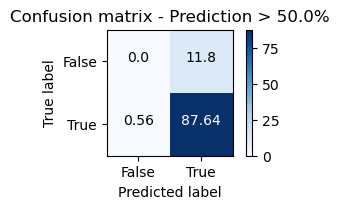

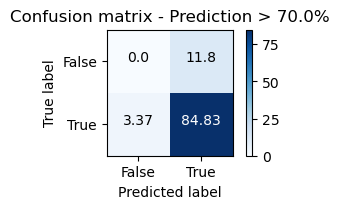

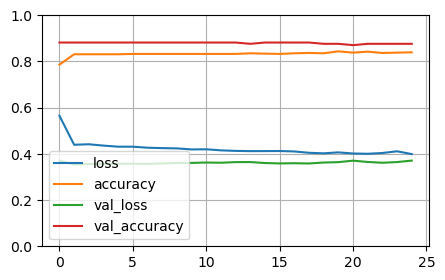

In [28]:
predictions_tf = model_tf.predict(X_test)
prepare_confus_matrix_tf(predictions_tf, y_test, limits=[0.5, 0.7])
graphic_history(history_tf)

### Entrenar Red Neuronal con TensorFlow/Keras ANN

In [29]:
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [30]:
# Inicializar y definir el modelo de red neuronal
model_tf2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_tf2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con el callback de EarlyStopping
history_tf2 = model_tf2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
_, accuracy_tf2 = model_tf2.evaluate(X_test, y_test)
print("\nPrecisión del modelo de Red Neuronal:", accuracy_tf2)

Epoch 1/50
12/12 [==============================] - 1s 17ms/step - loss: 4.4529 - accuracy: 0.7384 - val_loss: 1.3441 - val_accuracy: 0.8820
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 1.1964 - accuracy: 0.7173 - val_loss: 1.3638 - val_accuracy: 0.8820
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 1.3121 - accuracy: 0.7201 - val_loss: 0.5222 - val_accuracy: 0.8820
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.8441 - accuracy: 0.7722 - val_loss: 0.5825 - val_accuracy: 0.8034
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.7184 - accuracy: 0.7679 - val_loss: 0.5579 - val_accuracy: 0.8820
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.7217 - accuracy: 0.7595 - val_loss: 0.5653 - val_accuracy: 0.8820
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.7677 - accuracy: 0.8031 - val_loss: 0.5313 - val_accuracy: 0.8820
Epoch 8/50
12/12 [=

6/6 [==============================] - 0s 1ms/step
Precisión con 50.0%: 0.8820
Precisión con 70.0%: 0.7865


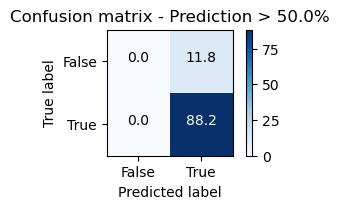

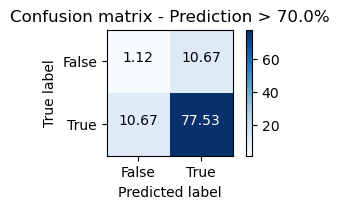

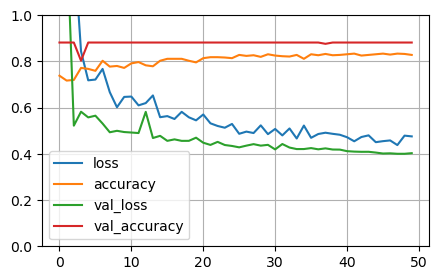

In [31]:
predictions_tf2 = model_tf2.predict(X_test)
prepare_confus_matrix_tf(predictions_tf2, y_test, limits=[0.5, 0.7])
graphic_history(history_tf2)

### Entrena modelo TensorFlow/Keras ANN con utilización de Embeddings 

Los embeddings de palabras son útiles en tareas de procesamiento de lenguaje natural (NLP) ya que permiten a los modelos aprender de manera más efectiva la semántica y el contexto de las palabras, incluso cuando se enfrentan a palabras que no están presentes en el conjunto de entrenamiento. 

In [32]:
# Dado que la capa de Embedding aprende representaciones vectoriales de las palabras, capturando la semántica y el contexto de las palabras
# se eliminan de X_train y X_test las últimas tres posiciones con los tokens de las etiquetas POS, de forma que no desvirtue los resultados

X_train_emb = [elemento[:3] for elemento in X_train]
X_test_emb = [elemento[:3] for elemento in X_test]
y_train_emb = y_train
y_test_emb = y_test

max_len = max(len(item) for item in X_train_emb)

In [33]:
# Inicializar y definir el modelo de aprendizaje profundo con embeddings
# La capa de Embedding aprende representaciones vectoriales de las palabras, capturando la semántica y el contexto de las palabras 
# en un espacio vectorial de baja dimensión, mientras que las capas densas subsiguientes pueden aprender patrones y relaciones más 
# complejos en esos vectores

model_tf_embe = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=50, input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_tf_embe.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con el callback de EarlyStopping
history_emb = model_tf_embe.fit(X_train_emb, y_train_emb, epochs=50, batch_size=32, validation_data=(X_test_emb, y_test_emb), callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
_, accuracy_tf_embe = model_tf_embe.evaluate(X_test_emb, y_test_emb)
print("Precisión del modelo de aprendizaje profundo con embeddings:", accuracy_tf_embe)

Epoch 1/50
23/23 [==============================] - 1s 9ms/step - loss: 0.6550 - accuracy: 0.7750 - val_loss: 0.5921 - val_accuracy: 0.8820
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.5462 - accuracy: 0.8312 - val_loss: 0.4746 - val_accuracy: 0.8820
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.4477 - accuracy: 0.8326 - val_loss: 0.4113 - val_accuracy: 0.8820
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.3598 - accuracy: 0.8411 - val_loss: 0.3838 - val_accuracy: 0.8820
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2539 - accuracy: 0.8917 - val_loss: 0.3819 - val_accuracy: 0.8652
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1678 - accuracy: 0.9592 - val_loss: 0.4022 - val_accuracy: 0.8539
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.1113 - accuracy: 0.9719 - val_loss: 0.4372 - val_accuracy: 0.8427
Epoch 8/50
23/23 [==

6/6 [==============================] - 0s 999us/step
Precisión con 50.0%: 0.8652
Precisión con 70.0%: 0.7584


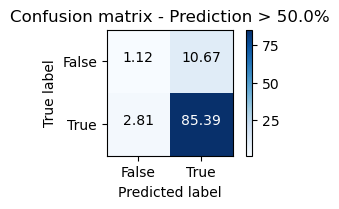

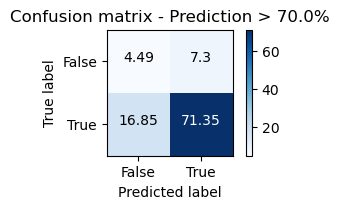

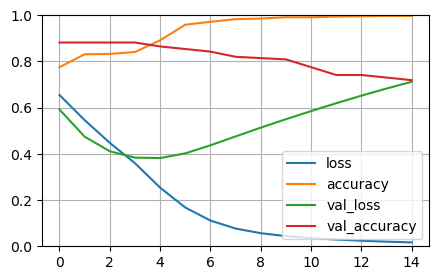

In [34]:
predictions_tf_embe = model_tf_embe.predict(X_test_emb)
prepare_confus_matrix_tf(predictions_tf_embe, y_test_emb, limits=[0.5, 0.7])
graphic_history(history_emb)

### Entrenar Red Neuronal con TensorFlow/Keras LSTM (Long Short-Term Memory)

In [35]:
# Definir el modelo LSTM
model_tf_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_tf_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo con el callback de EarlyStopping
history_tf_lstm = model_tf_lstm.fit(X_train_emb, y_train_emb, epochs=20, batch_size=32, validation_data=(X_test_emb, y_test_emb), callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
_, accuracy_tf_lstm = model_tf_lstm.evaluate(X_test_emb, y_test_emb)
print("\nPrecisión del modelo de Red Neuronal LSTM:", accuracy_tf_lstm)

Epoch 1/20
23/23 [==============================] - 6s 46ms/step - loss: 0.6449 - accuracy: 0.8186 - val_loss: 0.4899 - val_accuracy: 0.8820
Epoch 2/20
23/23 [==============================] - 0s 7ms/step - loss: 0.4531 - accuracy: 0.8312 - val_loss: 0.3610 - val_accuracy: 0.8820
Epoch 3/20
23/23 [==============================] - 0s 7ms/step - loss: 0.3441 - accuracy: 0.8312 - val_loss: 0.3526 - val_accuracy: 0.8820
Epoch 4/20
23/23 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.8819 - val_loss: 0.4521 - val_accuracy: 0.8315
Epoch 5/20
23/23 [==============================] - 0s 7ms/step - loss: 0.1131 - accuracy: 0.9592 - val_loss: 0.6262 - val_accuracy: 0.7753
Epoch 6/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0780 - accuracy: 0.9662 - val_loss: 0.7086 - val_accuracy: 0.7753
Epoch 7/20
23/23 [==============================] - 0s 7ms/step - loss: 0.0583 - accuracy: 0.9789 - val_loss: 0.7845 - val_accuracy: 0.7978
Epoch 8/20
23/23 [=

6/6 [==============================] - 1s 3ms/step
Precisión con 50.0%: 0.8820
Precisión con 70.0%: 0.8371


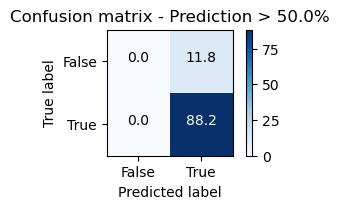

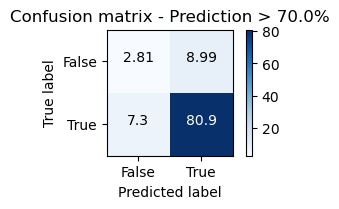

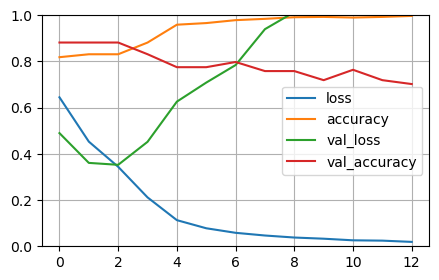

In [36]:
predictions_tf_lstm = model_tf_lstm.predict(X_test_emb)
prepare_confus_matrix_tf(predictions_tf_lstm, y_test_emb, limits=[0.5, 0.7])
graphic_history(history_tf_lstm)

In [37]:
%pip install transformers
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [67]:
# Preparamos datos para entrenar y probar modelo bert
B_train, B_test, c_train, c_test = train_test_split(term_list, y, test_size=test_split, random_state=42)



In [68]:
# Se revisa si existe desequilibrio en los datos de entrenamiento

# Calcular la cantidad de muestras en cada clase
counts = np.bincount(c_train)

# Calcular el peso de cada clase
class_weights = torch.FloatTensor([1/count for count in counts])

print(class_weights)

tensor([0.0083, 0.0017])


In [70]:
# Cargamos el tokenizador y el modelo_bert preentrenado
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
modelo_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Convertimos nuestras frases en secuencias numéricas
secuencias = tokenizer_bert(B_train, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Creamos una lista de tensores de etiquetas
# etiquetas = torch.tensor(c_train)
etiquetas = torch.LongTensor(c_train)

# Entrenamos el modelo_bert
modelo_bert.train()
optimizador = torch.optim.AdamW(modelo_bert.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizador, 1.0, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

for i in range(20): # número de épocas
   optimizador.zero_grad()
   salidas = modelo_bert(**secuencias, labels=etiquetas)
   pérdida = salidas.loss
   pérdida.backward()
   optimizador.step()

# Usamos el modelo_bert para predecir la relevancia de nuevas frases
nuevas_secuencias = tokenizer_bert(B_test, padding=True, truncation=True, max_length=512, return_tensors="pt")
salidas = modelo_bert(**nuevas_secuencias)
predicciones = salidas.logits.softmax(dim=-1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [75]:
# Desactiva la utilización de números con notación científica
np.set_printoptions(suppress=True)

predicciones_bert = predicciones.detach().numpy()
predicciones_bert = np.round(predicciones_bert, decimals=4)

# Devuelve la posición del elemento con el mayor valor (en la misma fila)
predicciones_bert = np.argmax(predicciones_bert, axis=1)
print("Pred.:", predicciones_bert)
print("Test:", c_test)

Pred.: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Test: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


In [76]:
# Cálculo de precisión
precision = accuracy_score(c_test, predicciones_bert)
print('Precisión: ', precision)

Precisión:  0.8820224719101124


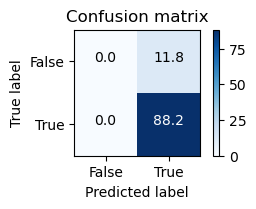

In [42]:
# Obtener la matriz de confusión
matriz_confusion = confusion_matrix(c_test, predicciones_bert)
mat_conf_percentage = calculate_confusion_matrix_percent(matriz_confusion)
plot_confusion_matrix(mat_conf_percentage)

### Comparación modelos de classificación

In [43]:
# Compare Performance of Classification Algorithms
def compareDifferentModels(a, b, scaler=StandardScaler()):
    """
    compare performance of classifiers
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    
    print('\nCompara Múltiples Clasificadores:\n')
    print('Precisión (Desv. Estándar):\n')
    
    models = []
    models.append(('LR', LogisticRegression(random_state=42)))
    models.append(('RF', RandomForestClassifier(random_state=42)))
    models.append(('SVM', SVC(random_state=42)))
    models.append(('LSVM', LinearSVC(random_state=42)))
    models.append(('DTC', DecisionTreeClassifier(random_state=42)))
    models.append(('MNB', MultinomialNB()))
    models.append(('GBC', GradientBoostingClassifier(random_state=42)))
    models.append(('CBC', CatBoostClassifier(iterations=100, depth=10, random_state=42, silent=True)))
    if scaler:
        models.append(('KNN', KNeighborsClassifier()))
        models.append(('GNB', GaussianNB()))
        models.append(('LDA', LinearDiscriminantAnalysis()))   
       
    # Normalizar los datos
    # scaler = MinMaxScaler()
    if scaler:
        a_normalized = scaler.fit_transform(a)
    else:
        a_normalized = a
      
    # Configuración de subtramas
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 8))
    axes = axes.flatten()  
      
    resultsAccuracy = []
    names = []
    i = 0
    for name, model in models:
        model.fit(a_normalized, b)
        kfold = KFold(n_splits=10)
        accuracy_results = cross_val_score(model, a_normalized, b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
        
        predicted = cross_val_predict(model, a_normalized, b, cv=kfold)
        
        # Calcula la matriz de confusión para cada modelo
        cm = confusion_matrix(b, predicted)
        total_predictions = cm.sum()  # Suma total de predicciones en el pliegue
        cm_percentage = (cm / total_predictions * 100).round(2)  # Multiplicar por el total de predicciones y redondear a dos decimales
        
        # Visualización de la matriz de confusión en una subtrama
        sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt=".2f", ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Real')
        axes[i].set_xticklabels(['False', 'True'])
        axes[i].set_yticklabels(['False', 'True'])
        i += 1

    # Agregar a los modelos la precisión y la desviación estándar
    returnResults = [(name, model, accuracy_results.mean(), accuracy_results.std()) for (name, model), accuracy_results in zip(models, resultsAccuracy)]

    # Ajustar el espacio entre subtramas y mostrar el gráfico
    plt.tight_layout()
    plt.show()
        
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Comparación de Algortimos: Precisión')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Accuracy Score')
    plt.show()
    return returnResults

def modelsDescription():
    print('\nLR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    print('MNB = MultinomialNB')
    print('GBC = GradientBoostingClassifier')
    print('LDA = LinearDiscriminantAnalysis')
    print('')

**Comparamos modelos de classificación con datos tokenizados y normalización**


Compara Múltiples Clasificadores:

Precisión (Desv. Estándar):

LR: 0.841318 (0.037540)
RF: 0.801966 (0.040302)
SVM: 0.841318 (0.037540)
LSVM: 0.841318 (0.037540)
DTC: 0.710789 (0.049443)
MNB: 0.841318 (0.037540)
GBC: 0.821080 (0.046515)
CBC: 0.834576 (0.044173)
KNN: 0.798608 (0.038009)
GNB: 0.779469 (0.040335)
LDA: 0.841318 (0.037540)


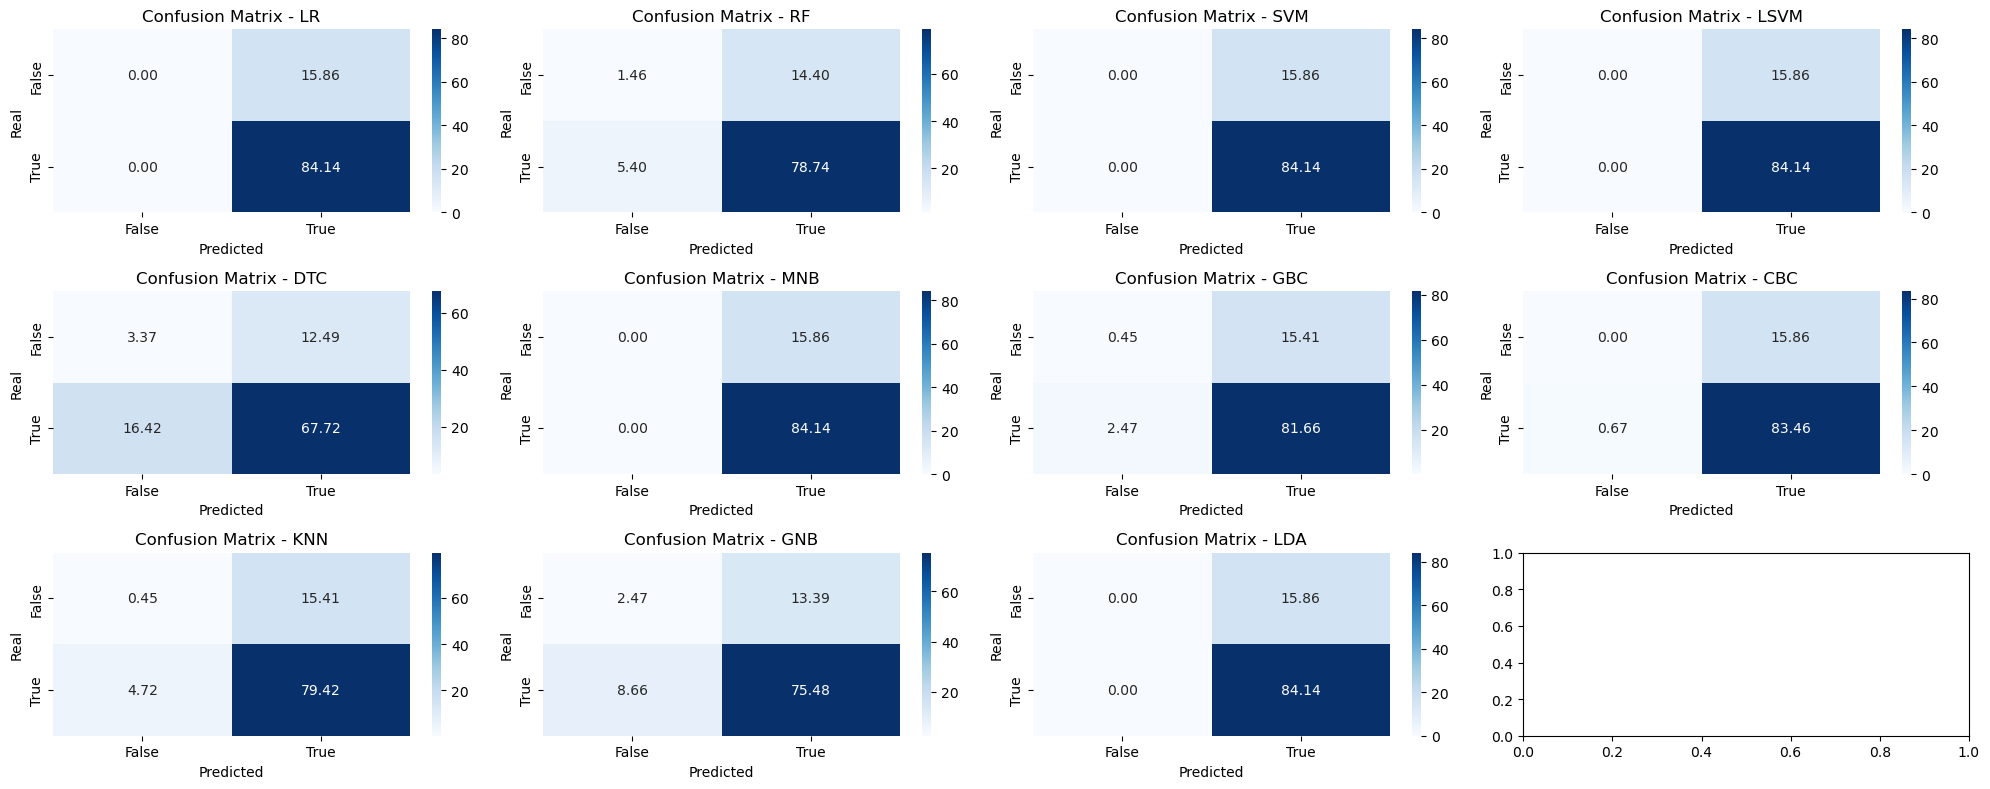

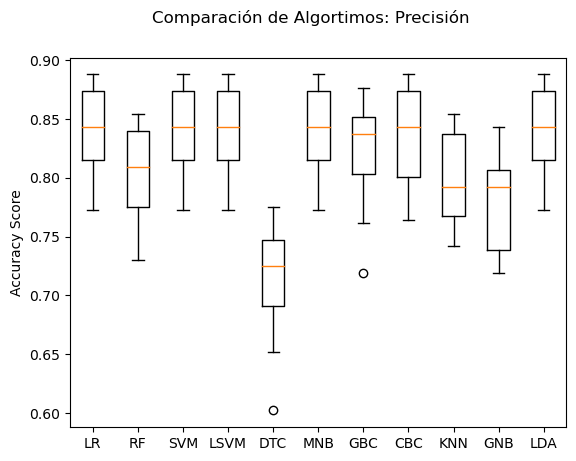

models_token: [('LR', LogisticRegression(random_state=42), 0.841317671092952, 0.037540249961741746), ('RF', RandomForestClassifier(random_state=42), 0.8019662921348315, 0.04030189226182627), ('SVM', SVC(random_state=42), 0.841317671092952, 0.037540249961741746), ('LSVM', LinearSVC(random_state=42), 0.841317671092952, 0.037540249961741746), ('DTC', DecisionTreeClassifier(random_state=42), 0.7107890704800818, 0.0494433214354018), ('MNB', MultinomialNB(), 0.841317671092952, 0.037540249961741746), ('GBC', GradientBoostingClassifier(random_state=42), 0.8210801838610827, 0.046515407822570826), ('CBC', <catboost.core.CatBoostClassifier object at 0x000002C8A38DEEE0>, 0.8345760980592442, 0.0441725362570322), ('KNN', KNeighborsClassifier(), 0.7986082737487232, 0.03800856354998589), ('GNB', GaussianNB(), 0.7794688457609806, 0.04033487868382759), ('LDA', LinearDiscriminantAnalysis(), 0.841317671092952, 0.037540249961741746)]

LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClas

In [44]:
# Compararamos distintos modelos y se utiliza MinMaxScaler() para normalizar los datos
# MinMaxScaler() escala los datos al rango específico entre 0 - 1 y conserva la forma de la distribución original
# Suele ser más adecuado que StandardScaler() (el utilizado por defecto) si se prefiere un rango específico para las características 
# y no se ven afectadas por valores atípicos
models_token = compareDifferentModels(X, y, MinMaxScaler())
print("models_token:", models_token)
modelsDescription()

**Comparamos modelos de classificación con datos vectorizados**


Compara Múltiples Clasificadores:

Precisión (Desv. Estándar):

LR: 0.841318 (0.037540)
RF: 0.835700 (0.038087)
SVM: 0.843565 (0.037890)
LSVM: 0.831205 (0.033392)
DTC: 0.795225 (0.026002)
MNB: 0.842441 (0.038396)
GBC: 0.840194 (0.037650)
CBC: 0.843565 (0.037890)


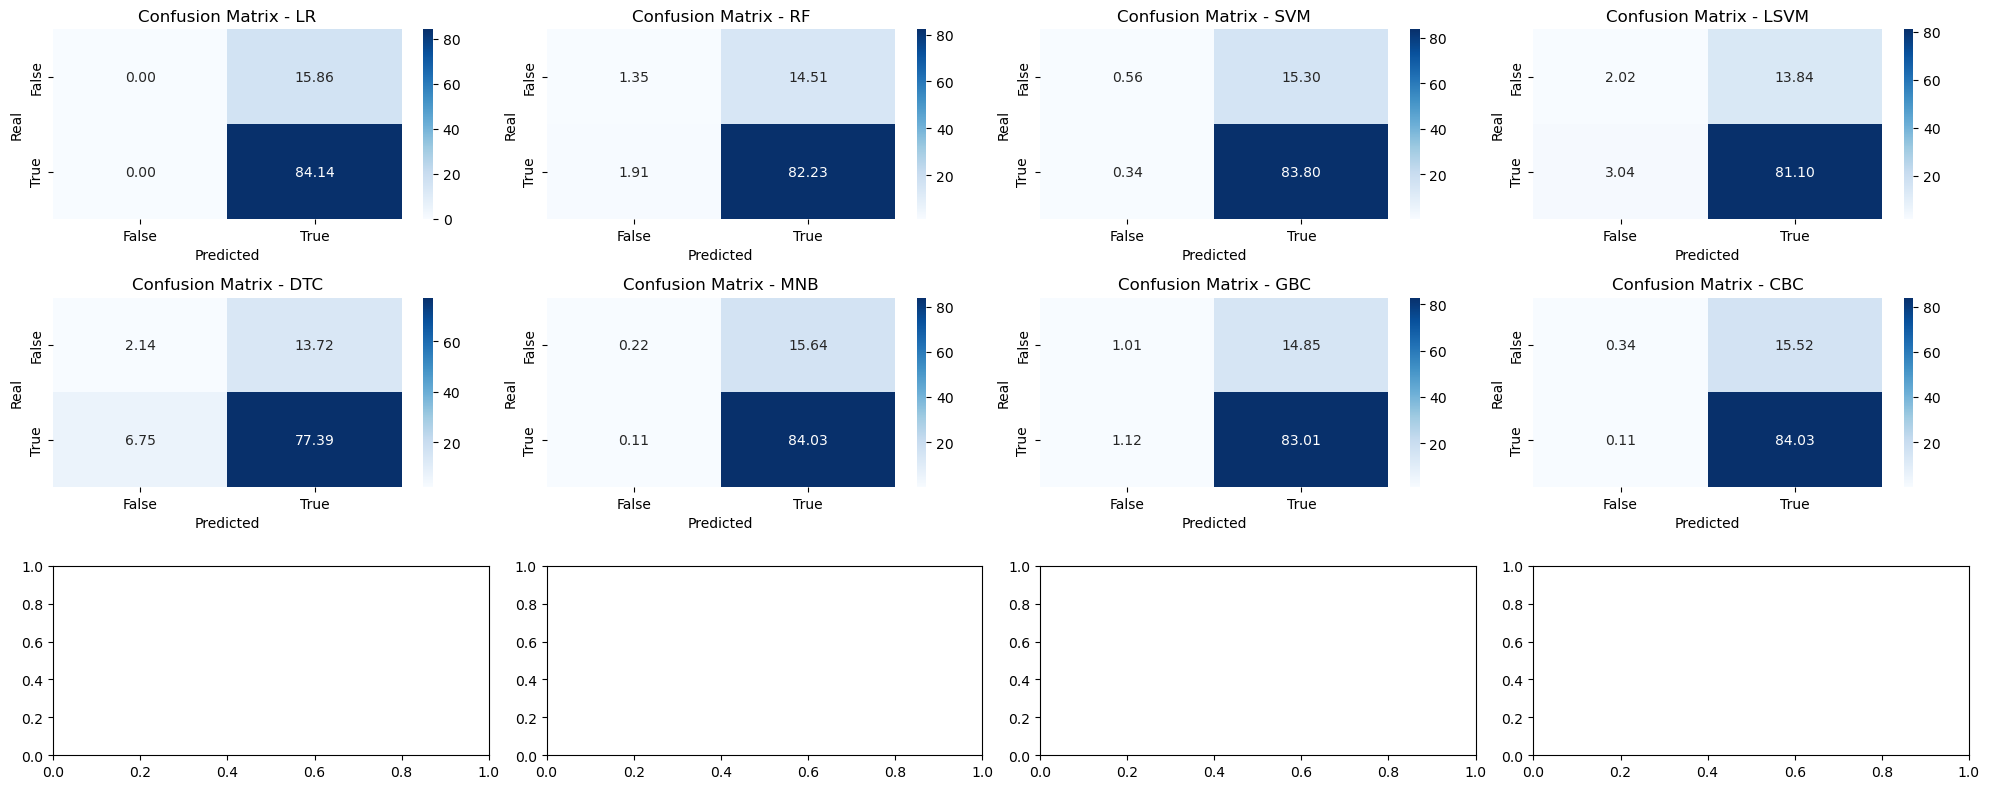

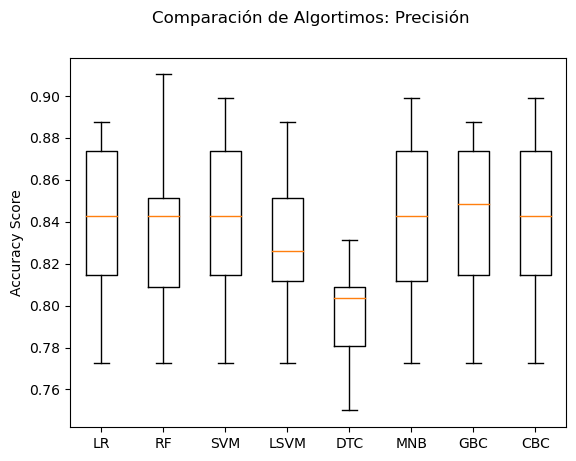


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier
MNB = MultinomialNB
GBC = GradientBoostingClassifier
LDA = LinearDiscriminantAnalysis



In [45]:
models_vect = compareDifferentModels(X_vect, y, False)
modelsDescription()

### Selección de 3 mejores modelos de clasificación con datos tokenizados 

In [46]:
# Ordenar los elementos basados en la suma de la tercera y cuarta posición
sorted_models = sorted(models_token, key=lambda x: x[2] + x[3], reverse=True)

# Seleccionar los tres elementos con los valores más altos
top_three_models_token = sorted_models[:3]

# Mostrar los tres elementos seleccionados
print(top_three_models_token)


[('LR', LogisticRegression(random_state=42), 0.841317671092952, 0.037540249961741746), ('SVM', SVC(random_state=42), 0.841317671092952, 0.037540249961741746), ('LSVM', LinearSVC(random_state=42), 0.841317671092952, 0.037540249961741746)]


**Teniendo los algoritmos de clasificación con mejores resultados, entrenamos con los datos de entrenamiento**

In [47]:
model_1 = top_three_models_token[0][1]
model_2 = top_three_models_token[1][1]
model_3 = top_three_models_token[2][1]

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)

# Calcular la precisión
accuracy_model_1 = accuracy_score(y_test, y_pred_1)
accuracy_model_2 = accuracy_score(y_test, y_pred_2)
accuracy_model_3 = accuracy_score(y_test, y_pred_3)

print(f"Precisión del modelo {top_three_models_token[0][0]}: {accuracy_model_1}")
print(f"Precisión del modelo {top_three_models_token[1][0]}: {accuracy_model_2}")
print(f"Precisión del modelo {top_three_models_token[2][0]}: {accuracy_model_3}")

Precisión del modelo LR: 0.8820224719101124
Precisión del modelo SVM: 0.8820224719101124
Precisión del modelo LSVM: 0.8539325842696629


c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Selección de 3 mejores modelos de clasificación con datos vectorizados

In [48]:
# Ordenar los elementos basados en la suma de la tercera y cuarta posición
sorted_models = sorted(models_vect, key=lambda x: x[2] + x[3], reverse=True)

# Seleccionar los tres elementos con los valores más altos
top_three_models_vect = sorted_models[:3]

# Mostrar los tres elementos seleccionados
print(top_three_models_vect)


[('SVM', SVC(random_state=42), 0.843564862104188, 0.03789020192002976), ('CBC', <catboost.core.CatBoostClassifier object at 0x000002C8A38DEAC0>, 0.843564862104188, 0.03789020192002976), ('MNB', MultinomialNB(), 0.8424412665985701, 0.038395703218399066)]


**Teniendo los algoritmos de clasificación con mejores resultados, entrenamos con los datos de entrenamiento**

In [49]:
model_4 = top_three_models_vect[0][1]
model_5 = top_three_models_vect[1][1]
model_6 = top_three_models_vect[2][1]

model_4.fit(X_train_v, y_train)
model_5.fit(X_train_v, y_train)
model_6.fit(X_train_v, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_4 = model_4.predict(X_test_v)
y_pred_5 = model_5.predict(X_test_v)
y_pred_6 = model_6.predict(X_test_v)

# Calcular la precisión
accuracy_model_4 = accuracy_score(y_test, y_pred_4)
accuracy_model_5 = accuracy_score(y_test, y_pred_5)
accuracy_model_6 = accuracy_score(y_test, y_pred_6)

print(f"Precisión del modelo {top_three_models_vect[0][0]}: {accuracy_model_4}")
print(f"Precisión del modelo {top_three_models_vect[1][0]}: {accuracy_model_5}")
print(f"Precisión del modelo {top_three_models_vect[2][0]}: {accuracy_model_6}")

Precisión del modelo SVM: 0.8764044943820225
Precisión del modelo CBC: 0.8764044943820225
Precisión del modelo MNB: 0.8820224719101124


### Crea un meta-estimador a partir de los modelos sklearn previamente entrenados

**Meta-estimador creado con los 3 modelos de clasificación entrenados con datos tokenizados**

c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lealp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

Precisión meta-estimador: 0.865


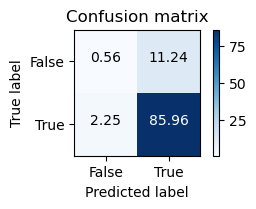

In [50]:
# Definir el meta-estimador (FinalEstimator)
final_estimator = GradientBoostingClassifier(random_state=42)

# Utiliza modelos ya entrenados
stacked_model = StackingClassifier(estimators=[('model1', model_1), ('model2', model_2), ('model3', model_3)], final_estimator=final_estimator)
stacked_model.fit(X_train, y_train)
final_prediction_m1 = stacked_model.predict(X_test)

# Evaluar el modelo
accuracy_st = stacked_model.score(X_test, y_test)
print("Precisión meta-estimador: {:.3f}".format(accuracy_st))
  
# Obtener la matriz de confusión
matriz_confusion = confusion_matrix(y_test, final_prediction_m1)
mat_conf_percentage = calculate_confusion_matrix_percent(matriz_confusion)
plot_confusion_matrix(mat_conf_percentage)


**Meta-estimador creado con los 3 modelos de clasificación entrenados con datos vectorizados**

Precisión meta-estimador: 0.848


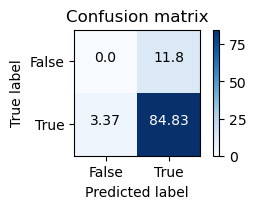

In [51]:
# Definir el meta-estimador (FinalEstimator)
final_estimator_2 = GradientBoostingClassifier(random_state=42)

# Utiliza modelos ya entrenados
stacked_model_2 = StackingClassifier(estimators=[('model3', model_3), ('model4', model_4), ('model5', model_5)], final_estimator=final_estimator_2)
stacked_model_2.fit(X_train_v, y_train_v)
final_prediction_m2 = stacked_model_2.predict(X_test_v)

# Evaluar el modelo
accuracy_st_2 = stacked_model_2.score(X_test_v, y_test_v)
print("Precisión meta-estimador: {:.3f}".format(accuracy_st_2))
  
# Obtener la matriz de confusión
matriz_confusion = confusion_matrix(y_test_v, final_prediction_m2)
mat_conf_percentage = calculate_confusion_matrix_percent(matriz_confusion)
plot_confusion_matrix(mat_conf_percentage)


### Pone en común todas las predicciones

**Definimos funciones a utilizar**

In [52]:
# Cambia el formato de las prediciones realizadas con modelos de TensorFlow/Keras al estilo Sklearn
def reshape_predictions(predictions):
    return np.resize(predictions, len(predictions))

# Obtiene el término original a partir de su token
def token_to_text(word_index, tokens):
    words = [word_index[token] for token in tokens if token != 0]
    texto = ' '.join(words)
    return texto

**Listamos y guardamos en formato CSV las predicciones de los distintos modelos**

In [53]:
# Cambia el formato a las prediciones realizadas con modelos de TensorFlow/Keras
predictions_tf_re = reshape_predictions(predictions_tf)
predictions_tf2_re = reshape_predictions(predictions_tf2)
predictions_tf_embe_re = reshape_predictions(predictions_tf_embe)
predictions_tf_lstm_re = reshape_predictions(predictions_tf_lstm)
limit_prediction = 0.5

# Aplicar la condición a cada array de predicciones
predictions_tf_1 = np.where(predictions_tf_re > limit_prediction, 1, 0)
predictions_tf_2 = np.where(predictions_tf2_re > limit_prediction, 1, 0)
predictions_tf_3 = np.where(predictions_tf_embe_re > limit_prediction, 1, 0)
predictions_tf_4 = np.where(predictions_tf_lstm_re > limit_prediction, 1, 0)

# Calcula la media de todas las predicciones (las predicciones de TF toma los valore 0 ó 1)
final_prediction = np.mean([predictions_tf_1, 
                            predictions_tf_2, 
                            predictions_tf_3, 
                            predictions_tf_4,
                            y_pred_1, 
                            y_pred_2, 
                            y_pred_3], 
                           axis=0)

predicted_labels = (final_prediction > limit_prediction).astype('int32')
accuracy_final_prediction = accuracy_score(y_test, predicted_labels)

# Calcula la media de las predicciones realizadas con TensorFlow
final_prediction_tf = np.mean([predictions_tf_re, 
                            predictions_tf2_re, 
                            predictions_tf_embe_re, 
                            predictions_tf_lstm_re], 
                           axis=0)

predicted_labels = (final_prediction_tf > limit_prediction).astype('int32')
accuracy_final_prediction_tf = accuracy_score(y_test, predicted_labels)

# Intercambia key y value para poder traducir los tokens a su término original
word_index_new = {value: key for key, value in word_index.items()}
word_index_pos_new = {value: key for key, value in word_index_pos.items()}

# Creamos la estructura de datos
test_data = []
for ind in range(len(X_test) - 1):
    test_data.append([
        token_to_text(word_index_new, X_test[ind][:3]),
        X_test[ind][:3],
        token_to_text(word_index_pos_new, X_test[ind][3:]),
        X_test[ind][3:],
        True if y_test[ind] == 1 else False,
        str(final_prediction[ind]).replace('.', ','),
        str(final_prediction_tf[ind]).replace('.', ','),
        str(predictions_tf_re[ind]).replace('.', ','), 
        str(predictions_tf2_re[ind]).replace('.', ','), 
        str(predictions_tf_embe_re[ind]).replace('.', ','), 
        str(predictions_tf_lstm_re[ind]).replace('.', ','), 
        str(final_prediction_m1[ind]).replace('.', ','),
        str(y_pred_1[ind]).replace('.', ','), 
        str(y_pred_2[ind]).replace('.', ','), 
        str(y_pred_3[ind]).replace('.', ','),
        str(final_prediction_m2[ind]).replace('.', ','),
        str(y_pred_4[ind]).replace('.', ','), 
        str(y_pred_5[ind]).replace('.', ','), 
        str(y_pred_6[ind]).replace('.', ',')
    ])

**Guarda fichero CSV con datos de predicción de cada término y modelo**

In [54]:
# Nombre del archivo CSV
csv_file = 'datos_'+ language + '.csv'

# Cabecera
cabecera = ['Term', 'Term_Token', 'POS', 'POS_Token', 'Is_gold_term', 
            'Mean_predictions', 'Mean_predictions_tf',  
            'Prediction_model_tf', 'Prediction_model_tf2', 'Prediction_model_tf_embe', 'Prediction_model_tf_lstm',
            'Predictions_m_tk', 'Prediction_model_tk_1', 'Prediction_model_tk_2', 'Prediction_model_tk_3',
            'Predictions_m_vc', 'Prediction_model_vc_4', 'Prediction_model_vc_5', 'Prediction_model_vc_6']

print('Test Data')
print(cabecera)
for item in test_data:
    print(item)
    
# Escribir la lista en el archivo CSV
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter=';', quotechar='"', quoting=csv.QUOTE_ALL)
    writer.writerow(cabecera)
    writer.writerows(test_data)
    
print('\nPredicciones guardadas en', csv_file)

Test Data
['Term', 'Term_Token', 'POS', 'POS_Token', 'Is_gold_term', 'Mean_predictions', 'Mean_predictions_tf', 'Prediction_model_tf', 'Prediction_model_tf2', 'Prediction_model_tf_embe', 'Prediction_model_tf_lstm', 'Predictions_m_tk', 'Prediction_model_tk_1', 'Prediction_model_tk_2', 'Prediction_model_tk_3', 'Predictions_m_vc', 'Prediction_model_vc_4', 'Prediction_model_vc_5', 'Prediction_model_vc_6']
['residency education', [30, 8, 0], 'noun noun', [1, 1, 0], True, '1,0', '0,8259298', '0,91269344', '0,67975026', '0,8693409', '0,8419346', '1', '1', '1', '1', '1', '1', '1', '1']
['rehabilitation sciences', [9, 233, 0], 'noun noun', [1, 1, 0], True, '1,0', '0,85716695', '0,8759013', '0,79467565', '0,87017506', '0,88791585', '1', '1', '1', '1', '1', '1', '1', '1']
['clinical performance', [10, 25, 0], 'adj noun', [2, 1, 0], True, '1,0', '0,82444966', '0,7183593', '0,6871032', '0,9689399', '0,9233961', '1', '1', '1', '1', '1', '1', '1', '1']
['psychometric theory', [137, 18, 0], 'adj noun'

### Prediciones con la media de resultados de modelos hecho con TensorFlow/Keras

Precisión con 40.0%: 0.8820
Precisión con 50.0%: 0.8820
Precisión con 60.0%: 0.8820
Precisión con 70.0%: 0.8427


[0.8820224719101124,
 0.8820224719101124,
 0.8820224719101124,
 0.8426966292134831]

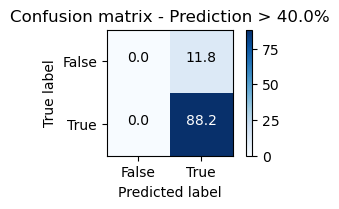

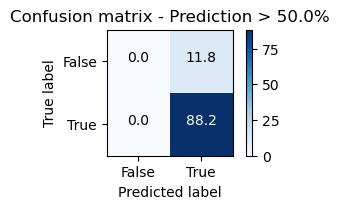

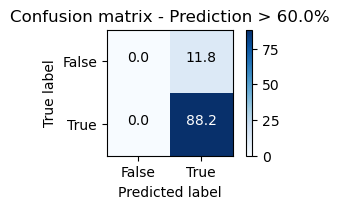

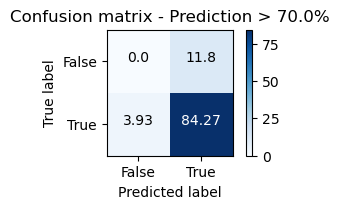

In [55]:
# Esta predicción supondría hacer una predicción con cada uno de los modelos de TensorFlow y calcular un promedio de ellas para tomar
# una decisión 
prepare_confus_matrix_tf(final_prediction_tf, y_test, limits=[0.4, 0.5, 0.6, 0.7])

### Prediciones con la media de todo el conjunto de modelos

Precisión con 40.0%: 0.8820
Precisión con 50.0%: 0.8820
Precisión con 60.0%: 0.8820
Precisión con 70.0%: 0.8820


[0.8820224719101124,
 0.8820224719101124,
 0.8820224719101124,
 0.8820224719101124]

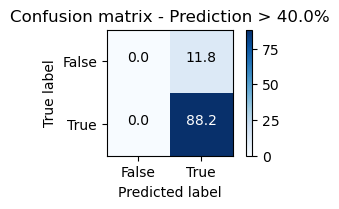

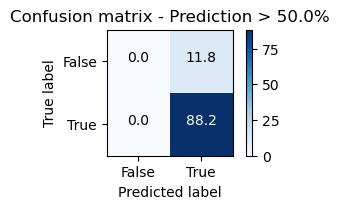

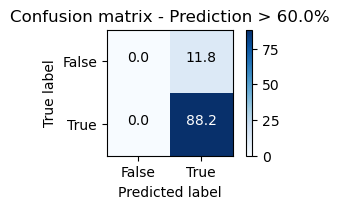

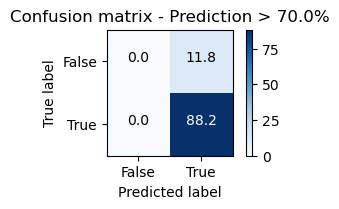

In [56]:
prepare_confus_matrix_tf(final_prediction, y_test, limits=[0.4, 0.5, 0.6, 0.7])

Predicciones Finales

In [57]:
numberChar = 50

# Esta precisión toma en cuenta los 4 modelos TF y los 3 mejores de clasificación con datos tokenizados
print(f'Precisión conjunto de modelos      \t: {accuracy_final_prediction:.2%}')

print('\nPrecisión modelos TensorFlow')
print('=' * numberChar)
print(f'Precisión modelo ANN FastForward 1 \t: {accuracy_tf:.2%}')
print(f'Precisión modelo ANN FastForward 2 \t: {accuracy_tf2:.2%}')
print(f'Precisión modelo Embedding         \t: {accuracy_tf_embe:.2%}')
print(f'Precisión modelo LSTM              \t: {accuracy_tf_lstm:.2%}')
print('-' * numberChar)
print(f'Precisión media modelos            \t: {accuracy_final_prediction_tf:.2%}')

print('\nPrecisión modelos Clasificación (datos tokenizados)')
print('=' * numberChar)
print(f'Precisión modelo 1 - {top_three_models_token[0][0]}  \t\t: {accuracy_model_1:.2%}')
print(f'Precisión modelo 2 - {top_three_models_token[1][0]}  \t\t: {accuracy_model_2:.2%}')
print(f'Precisión modelo 3 - {top_three_models_token[2][0]}  \t\t: {accuracy_model_3:.2%}')
print('-' * numberChar)
print(f'Precisión meta-estimador\t\t: {accuracy_st:.2%}')

print('\nPrecisión modelos Clasificación (datos vectorizados)')
print('=' * numberChar)
print(f'Precisión modelo 4 - {top_three_models_vect[0][0]}   \t\t: {accuracy_model_4:.2%}')
print(f'Precisión modelo 5 - {top_three_models_vect[1][0]}   \t\t: {accuracy_model_5:.2%}')
print(f'Precisión modelo 6 - {top_three_models_vect[2][0]}   \t\t: {accuracy_model_6:.2%}')
print('-' * numberChar)
print(f'Precisión meta-estimador\t\t: {accuracy_st_2:.2%}')

Precisión conjunto de modelos      	: 88.20%

Precisión modelos TensorFlow
Precisión modelo ANN FastForward 1 	: 87.64%
Precisión modelo ANN FastForward 2 	: 88.20%
Precisión modelo Embedding         	: 86.52%
Precisión modelo LSTM              	: 88.20%
--------------------------------------------------
Precisión media modelos            	: 88.20%

Precisión modelos Clasificación (datos tokenizados)
Precisión modelo 1 - LR  		: 88.20%
Precisión modelo 2 - SVM  		: 88.20%
Precisión modelo 3 - LSVM  		: 85.39%
--------------------------------------------------
Precisión meta-estimador		: 86.52%

Precisión modelos Clasificación (datos vectorizados)
Precisión modelo 4 - SVM   		: 87.64%
Precisión modelo 5 - CBC   		: 87.64%
Precisión modelo 6 - MNB   		: 88.20%
--------------------------------------------------
Precisión meta-estimador		: 84.83%


### Guardamos modelos

In [58]:
if path_model.endswith("/"):
    path_model = path_model[:-1]  # Elimina el último carácter

model_name = path_model + "/model_review_terms_" + language

In [59]:
if not os.path.exists(path_model):
    os.makedirs(path_model)
    print(f"Directorio '{path_model}' creado.")
else:
    print(f"El directorio '{path_model}' ya existe.")

El directorio './models' ya existe.


**Guardamos modelo generado con PyTorch (Bert)**

In [77]:
state = {
    'model': modelo_bert.state_dict(),
    'tokenizer': tokenizer_bert
}
torch.save(state, model_name + '_bert.pth')
print(f'Modelo {model_name}_bert.pth guardado')

Modelo ./models/model_review_terms_eng_bert.pth guardado


**Guardamos modelos generados con Scikit-learn**

In [61]:
with open(model_name + '_tk.pkl', 'wb') as file:
    pickle.dump(stacked_model, file)
    
print(f'Modelo {model_name}_tk.pkl guardado')

with open(model_name + '_vc.pkl', 'wb') as file:
    pickle.dump(stacked_model, file)
    
print(f'Modelo {model_name}_vc.pkl guardado')

Modelo ./models/model_review_terms_eng_tk.pkl guardado
Modelo ./models/model_review_terms_eng_vc.pkl guardado


**Guardamos modelos generados con TensorFlow**

In [62]:
# Guardamos model_tf
model_tf.save(model_name + '_tf.keras')
print(f'Modelo {model_name}._tf.keras guardado')

# Guardamos model_tf2
model_tf2.save(model_name + '_tf2.keras')
print(f'Modelo {model_name}._tf2.keras guardado')

# Guardamos model_tf_embe
model_tf_embe.save(model_name + '_tf_embe.keras')
print(f'Modelo {model_name}_tf_embe.keras guardado')

# Guardamos model_tf_lstm
model_tf_lstm.save(model_name + '_tf_lstm.keras')
print(f'Modelo {model_name}_tf_lstm.keras guardado')

Modelo ./models/model_review_terms_eng._tf.keras guardado
Modelo ./models/model_review_terms_eng._tf2.keras guardado
Modelo ./models/model_review_terms_eng_tf_embe.keras guardado
Modelo ./models/model_review_terms_eng_tf_lstm.keras guardado
